In [75]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [76]:
def root_mse(x, y):
    if len(x) != len(y):
        return "Error: The two arguments must have the same length"
    n = len(x)
    sq_err = [(x[i] - y[i]) ** 2 for i in range(n)]
    mse = sum(sq_err) / n
    # mse = np.square(np.subtract(x, y)).mean()
    return np.sqrt(mse)


def multi_rmse(observed, predicted):
    # Ensure the lists are of the same dimensions
    if len(observed) != len(predicted):
        raise ValueError("The number of rows in observed and predicted arrays must be the same")
    
    num_rows = len(observed)
    if num_rows == 0:
        raise ValueError("The input arrays must not be empty")
    
    num_columns = len(observed[0])
    for row in observed:
        if len(row) != num_columns:
            raise ValueError("All rows in the observed array must have the same number of columns")
    for row in predicted:
        if len(row) != num_columns:
            raise ValueError("All rows in the predicted array must have the same number of columns")
    
    # Calculate RMSE for each column
    columnwise_rmse = []
    for col in range(num_columns):
        squared_errors = [(observed[row][col] - predicted[row][col]) ** 2 for row in range(num_rows)]
        mean_squared_error = sum(squared_errors) / num_rows
        rmse = math.sqrt(mean_squared_error)
        columnwise_rmse.append(rmse)
    
    return columnwise_rmse


In [77]:
# Generating a sample multivariate time series dataset
def generate_data(num_samples=1000, num_features=3, timesteps=10):
    np.random.seed(42)
    data = np.random.rand(num_samples, num_features)
    return data

# Preprocessing the data
def preprocess_data(data, timesteps=10):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    X, y = np.array(X), np.array(y)
    
    # Normalizing the data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    y = scaler.transform(y)
    
    return X, y, scaler

# Build the CNN model
# def build_model(timesteps, num_features):
#     model = Sequential()
#     model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, num_features)))
#     model.add(Flatten())  
#     model.add(Dense(50, activation='relu'))
#     model.add(Dense(num_features))
#     model.compile(optimizer='adam', loss='mse')
#     return model

def build_model(timesteps, num_features):
    model = Sequential()
    
    # First Conv1D layer
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, num_features)))
    model.add(Dropout(0.2))  # Optional: Add dropout to prevent overfitting
    
    # Second Conv1D layer
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model.add(Dropout(0.2))  # Optional: Add dropout to prevent overfitting
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_features))
    
    model.compile(optimizer='adam', loss='mse')
    return model

def plot_series(series, attr):
    for i in range(len(attr)):
        title = "Plot of "+str(attr[i])
        actual = series.iloc[:,i]
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel(attr[i])
        plt.plot(actual)
        plt.show()

# Main function
if __name__ == "__main__":
    # Parameters
    num_samples = 1000
    # num_features = 3
    timesteps = 10
    mse_list = []
    rmse_list = []
    mae_list = []
    rsqr_list = []

    # Generate and preprocess data
    # data = generate_data(num_samples, num_features)
    # data = pd.read_csv("waterTank_Golden_reduced.csv", index_col=0, header=0)
    # data.index.freq= 'ms'
    file = "phy_cps.csv"
    df = pd.read_csv(file, index_col=0)
    data = df.values
    features = df.columns
    num_features = len(features)
    X, y, scaler = preprocess_data(data, timesteps)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build and train the model
    model = build_model(timesteps, num_features)
    model.summary()
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
    
    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}")
    
    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    real_y_test = scaler.inverse_transform(y_test)
    # # Example: Print the first 5 predictions
    # print("First 5 Predictions:")
    # print(predictions[:5])

    for i in range(1, num_features+1):
        mse = mean_squared_error(predictions[i], real_y_test[i])
        mse_list.append(mse)
        print(f'Mean Squared Error: {mse}')

        rmse = np.sqrt(mse)
        rmse_list.append(rmse)
        print(f'Root Mean Squared Error: {rmse}')

        mae = mean_absolute_error(predictions[i], real_y_test[i])
        mae_list.append(mae)
        print(f'Mean Absolute Error: {mae}')

        r_sqr = r2_score(predictions[i], real_y_test[i])
        rsqr_list.append(r_sqr)
        print(f'R2 Score: {r_sqr}')
    
# for i in range(len(data[0])):
#     title = "Plot of "
#     actual = data[:,i]
#     plt.title(title)
#     plt.xlabel("Timestep")
#     # plt.ylabel(attr[i])
#     plt.plot(actual)
#     plt.show()
    # print("The mean squared errors are as follows:")
    # print(mean_squared_error(predictions, y_test))
    
    # print("The root mean squared errors are as follows:")
    # print(root_mse(predictions, y_test))
    
    # print("The mean absolute errors are as follows:")
    # print(mean_absolute_error(predictions, y_test))
    
    # print("The R2-score values are as follows:")
    # print(r2_score(predictions, y_test))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 9, 64)             832       
                                                                 
 dropout_16 (Dropout)        (None, 9, 64)             0         
                                                                 
 conv1d_17 (Conv1D)          (None, 8, 32)             4128      
                                                                 
 dropout_17 (Dropout)        (None, 8, 32)             0         
                                                                 
 flatten_8 (Flatten)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 50)                12850     
                                                                 
 dense_17 (Dense)            (None, 6)                

In [78]:
print(mean_squared_error(predictions[1], y_test[1]))
print(multi_rmse(predictions, y_test))

356348.2707480572
[947.2658677839529, 911.6687236978145, 1405.9131339705102, 0.10001721157466584, 0.10033059349931947, 2118.0210196229605]


In [79]:
print(mse_list)
print(rmse_list)
print(mae_list)
print(rsqr_list)

[2065.2689563441727, 10780.42657887512, 5976.943843087381, 2765.810368270729, 7524.336493238609, 8924.989087568456]
[45.445230292563956, 103.82883308058085, 77.31069682189768, 52.59097230771389, 86.74293339078757, 94.47216038372603]
[27.469167637328308, 72.7169721449415, 50.06717995430032, 32.76845655217767, 51.94866138820847, 60.96652249495196]
[0.9928855001641376, 0.994397450207471, 0.9940791099477297, 0.9864881108855997, 0.9817558053251185, 0.9939396701156465]


In [80]:
def ListShape(list):
    rows = len(list)
    # if True:
    if isinstance(list[0], int):
        return "Error: object is a scalar/number"
    cols = len(list[0]) if rows > 0 else 0
    return rows, cols

print(ListShape(predictions))

(482, 6)


In [81]:
# print(multi_rmse(y_test, predictions))
# print(multi_rmse(predictions, y_test))
# [0.32743663 0.35012764 0.32282214]

In [82]:
data = pd.read_csv(file, index_col=0)
num_features = len(data.columns)
num_features

6

In [83]:
data = pd.read_csv(file, index_col=0)
num_features = len(data.columns)
data.columns

Index(['Tank_1', 'Tank_2', 'Tank_3', 'Pump_1', 'Pump_2', 'Flow_sensor'], dtype='object')

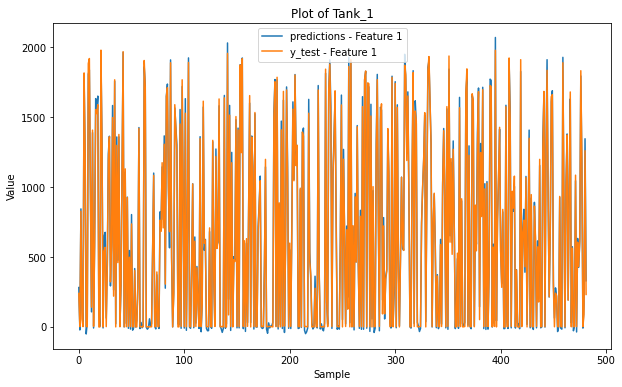

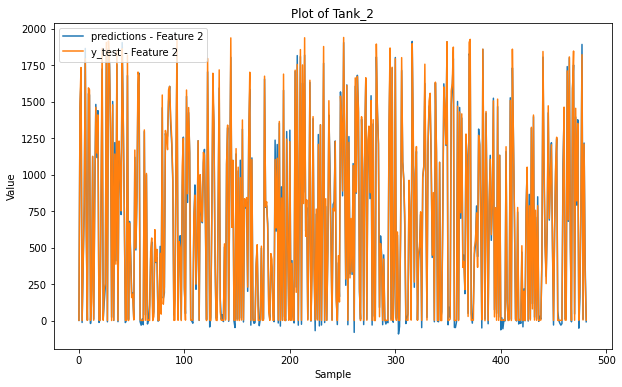

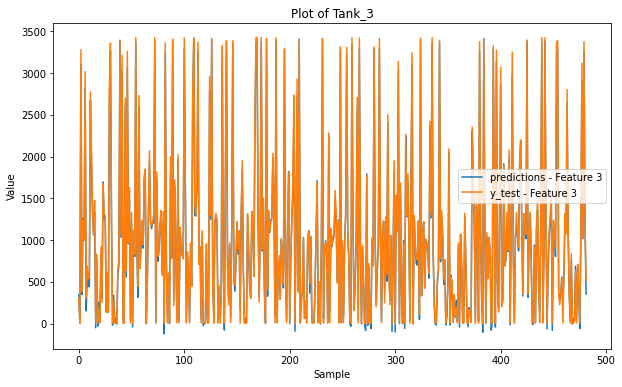

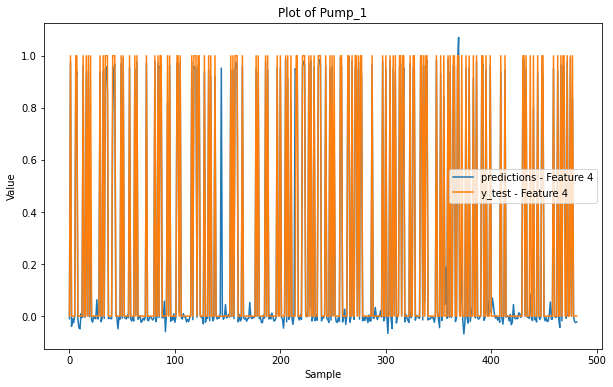

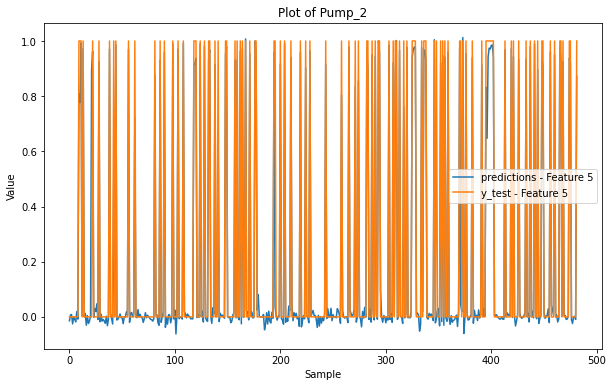

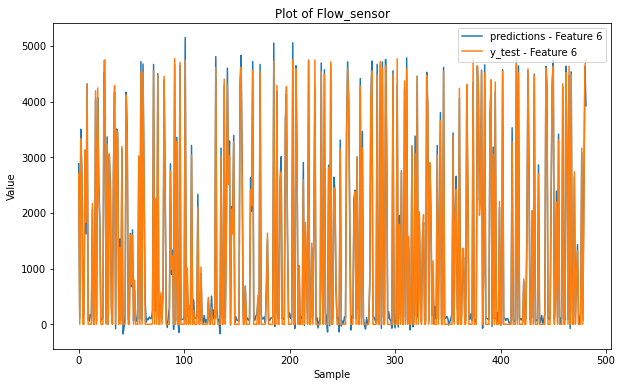

In [84]:
# Plot the predictions
n = ListShape(predictions)[1]
for i in range(n):
    plt.figure(figsize=(10, 6))
    plt.plot(predictions[:, i], label=f'predictions - Feature {i+1}')
    plt.plot(real_y_test[:, i], label=f'y_test - Feature {i+1}')
    plt.title(f'Plot of {data.columns[i]}')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

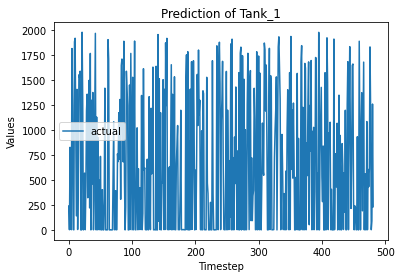

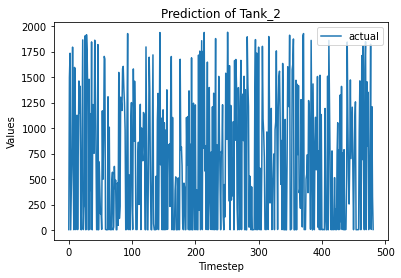

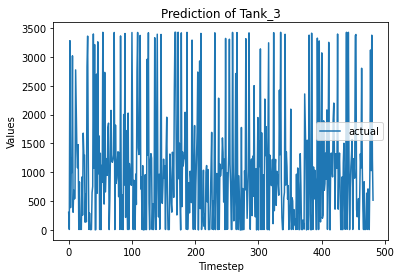

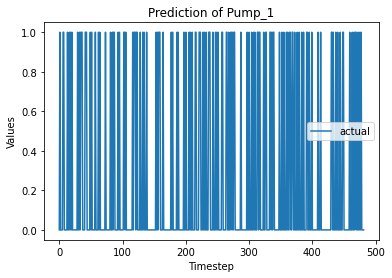

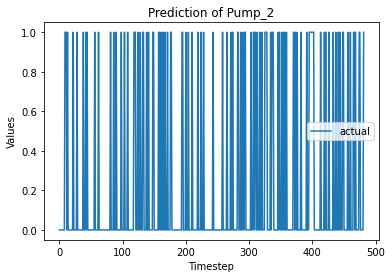

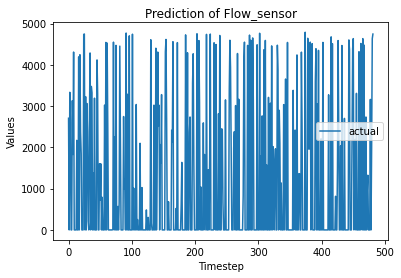

In [85]:
#plot the entire dataset
for i in range(len(features)):
    title = "Prediction of {}".format(features[i])
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(real_y_test[:,i], label="actual")
    # plt.plot(predictions[:,i], label="Forecast")
    plt.legend()
    plt.show()